# [Lecture 12 - Multilevel Models](https://www.youtube.com/watch?v=iwVqiiXYeC4)

In [1]:
%run init_notebook.py

Module aliases imported by init_notebook.py:
--------------------------------------------
import numpy as np

import pandas as pd

import statsmodels.formula.api as smf

import pymc as pm

import xarray as xr

import arviz as az

import utils as utils

from scipy import stats as stats

from matplotlib import pyplot as plt

Watermark:
----------
Last updated: 2025-02-12T13:56:05.990156+01:00

Python implementation: CPython
Python version       : 3.10.12
IPython version      : 8.15.0

Compiler    : MSC v.1936 64 bit (AMD64)
OS          : Windows
Release     : 10
Machine     : AMD64
Processor   : Intel64 Family 6 Model 158 Stepping 9, GenuineIntel
CPU cores   : 4
Architecture: 64bit

matplotlib : 3.9.2
pymc       : 5.8.0
xarray     : 2023.8.0
scipy      : 1.11.2
statsmodels: 0.14.0
IPython    : 8.15.0
watermark  : 2.5.0
numpy      : 1.24.4
arviz      : 0.16.1
pandas     : 2.1.0



# Repeat observations
At the end of [Lecture 11 on Ordered Categories](<Lecture 11 - Ordered Categories.ipynb>), McElreath alluded to leveraging repeat observations of stories and participants in the Trolley dataset to improve estimation

Using reapeat observations can lead to better estimators

In [2]:
TROLLEY = utils.load_data("Trolley")
N_TROLLEY_RESPONSES = len(TROLLEY)
N_RESPONSE_CATEGORIES = TROLLEY.response.max()
TROLLEY.head()

,case,response,order,id,age,male,edu,action,intention,contact,story,action2
0,cfaqu,4,2,96;434,14,0,Middle School,0,0,1,aqu,1
1,cfbur,3,31,96;434,14,0,Middle School,0,0,1,bur,1
2,cfrub,4,16,96;434,14,0,Middle School,0,0,1,rub,1
3,cibox,3,32,96;434,14,0,Middle School,0,1,1,box,1
4,cibur,3,4,96;434,14,0,Middle School,0,1,1,bur,1


In [3]:
def plot_trolly_response_distribution(variable, n_display=50, error_kwargs={}):

    gb = TROLLEY[[variable, 'response']].groupby(variable)
    plot_data = gb.mean()
    plot_data.reset_index(inplace=True)
    plot_data = plot_data.iloc[:n_display]

    # IQR 
    plot_data.loc[:, 'error_lower'] = plot_data['response'] - gb.quantile(.25).reset_index()['response']
    plot_data.loc[:, 'error_upper'] = gb.quantile(.75).reset_index()['response'] - plot_data['response']

    utils.plot_scatter(plot_data.index, plot_data.response, color='C0') 
    utils.plot_errorbar(
        plot_data.index,
        plot_data.response,
        plot_data.error_lower.abs(),
        plot_data.error_upper.abs(), colors='C0',
        **error_kwargs
    )
    plt.ylim(1, 7)
    plt.xlabel(f"{variable} index")
    plt.ylabel('response')
    plt.title(f"{variable} response distribution")

## Variability in Story Responses
### Story repeats
12 stories

In [4]:
TROLLEY.groupby('story').count()['case']

story
aqu     662
boa     662
box    1324
bur    1324
car     662
che     662
pon     662
rub     662
sha     662
shi     662
spe     993
swi     993
Name: case, dtype: int64

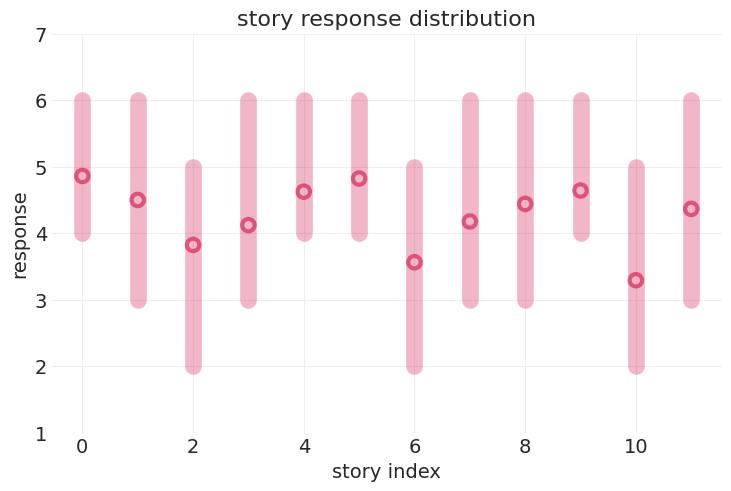

In [5]:
plot_trolly_response_distribution('story')

### Variatbility Participant Responses
331 individuals

In [6]:
TROLLEY.groupby('id').count()['case']

id
96;434    30
96;445    30
96;451    30
96;456    30
96;458    30
          ..
98;225    30
98;227    30
98;245    30
98;257    30
98;299    30
Name: case, Length: 331, dtype: int64

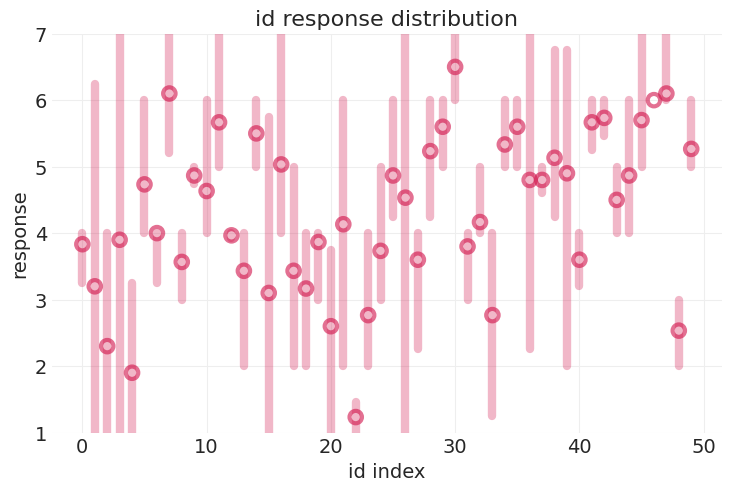

In [7]:
plot_trolly_response_distribution('id', error_kwargs={'error_width': 6})

### Ways of modeling variability across observations

#### Complete Pooling

$$
\begin{align}
R_i &\sim \text{OrderedLogit}(\phi_i, \alpha) \\
\phi_i &= \beta
\end{align}
$$

- global $\beta$ parameter
- treat all unique categories (e.g. story and/or participant) as the same
- **underfits data** because model isn't flexible enough

#### No Pooling

$$
\begin{align}
R_i &\sim \text{OrderedLogit}(\phi_i, \alpha) \\
\phi_i &= \beta_{S[i]}
\end{align}
$$

- treat all unique categories as independent; each category gets its own $\beta_{S}$
- model has "anderograde amnesia"
  - doesn't share information across consecutive observations
  - inefficient
- **overfits data** because model too flexible, and fits to individual noise
  
#### Partial Pooling (Multi-level Models)

$$
\begin{align}
R_i &\sim \text{OrderedLogit}(\phi_i, \alpha) \\
\phi_i &= \beta_{S[i]} \\
\beta_i &\sim \text{Prior}_\beta(\eta) \\
\eta &\sim \text{PopulationPrior}(\theta)
\end{align}
$$

- parameters are drawn from a global distribution that is shared across the population
- allows flexibility without overfitting
- shares information across observations
  - has "memory"
  - more efficient
    - learns faster
  - get adaptive regularization for free
    - **resists overfitting**
  - improves estimates for imbalanced sampling

# Case Study: Reed Frog Survival
- 48 group; "tanks"
- Treatment: density, size, and predation level
- Outcome: survival rate

In [8]:
FROGS = utils.load_data("reedfrogs")
N_TANKS = len(FROGS)
FROGS.head()

,density,pred,size,surv,propsurv
0,10,no,big,9,0.9
1,10,no,big,10,1.0
2,10,no,big,7,0.7
3,10,no,big,10,1.0
4,10,no,small,9,0.9


In [17]:
FROGS

,density,pred,size,surv,propsurv
0,10,no,big,9,0.900000
1,10,no,big,10,1.000000
2,10,no,big,7,0.700000
3,10,no,big,10,1.000000
4,10,no,small,9,0.900000
5,10,no,small,9,0.900000
6,10,no,small,10,1.000000
7,10,no,small,9,0.900000
8,10,pred,big,4,0.400000
9,10,pred,big,9,0.900000


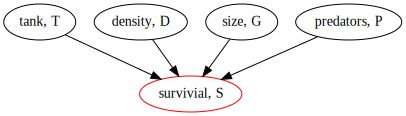

In [9]:
utils.draw_causal_graph(
    edge_list=[
        ("T", "S"),
        ("D", "S"),
        ("G", "S"),
        ("P", "S")
    ],
    node_props={
        "T": {"label": "tank, T"},
        "S": {"label": "survivial, S", "color": "red"},
        "D": {"label": "density, D"},
        "G": {"label": "size, G"},
        "P": {"label": "predators, P"},
    }
)

- $T$: tank ID
- $D$: tank density - the number of tadpoles in each tank - counts
- $G$: tank size - categorical (large/small)
- $P$: presence/absence of predators - categorical
- $S$: survival, the number of tadpoles that survived - counts
- propsurv: survival rate $\frac{S}{D}$

### Plot average survival rates for all tanks

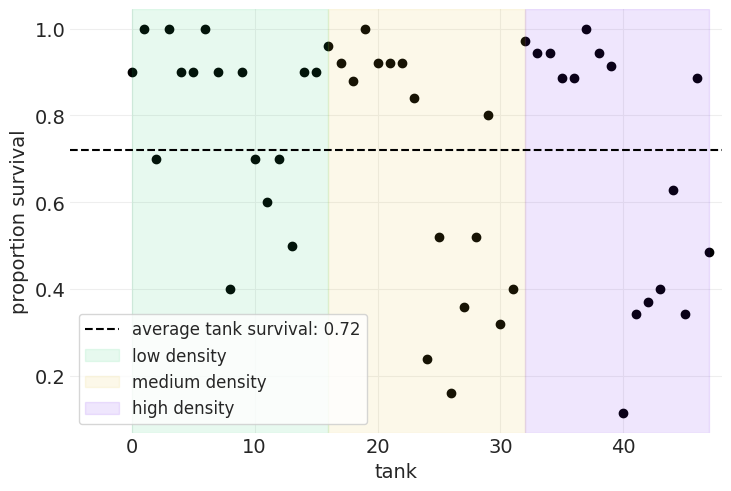

In [10]:
plt.scatter(FROGS.index, FROGS.propsurv, color='k')

# Plot average survival rate across tanks
global_mean = FROGS.propsurv.mean()
plt.axhline(global_mean, color='k', linestyle='--', label=f"average tank survival: {global_mean:1.2}")

# Highlight different densities
density_change = FROGS[FROGS.density.diff() > 0].index.tolist()
density_change.append(N_TANKS-1)
start = 0
density_labels = ['low', 'medium', 'high']
for ii in range(3):
    end = density_change[ii]
    plt.axvspan(start, end, alpha=.1, label=f"{density_labels[ii]} density", color=f'C{ii+2}')
    start = end

plt.xlabel("tank")
plt.xlim([-5, N_TANKS])
plt.ylabel("proportion survival")
plt.legend();

## Let's build a (multi-level) model

$$
\begin{align*}
S_i &\sim \text{Binomial}(D_i, p_i) \\
\text{logit}(p_i) &= \alpha_{T[i]} \\
\alpha_j &\sim \text{Normal}(\bar \alpha, \sigma_?) \\ 
\bar \alpha &\sim \text{Normal}(0, 1.5) \\
\end{align*}
$$


### What about the prior variance $\sigma$? 

For now, let's try setting $\sigma$ manually via using cross-validation to see the effect on the multi-level model (we'll estiamate it later)

In [11]:
# Set up data / coords

N_SURVIVED = FROGS['surv'].astype(float)
N_TRIALS = FROGS['density'].values.astype(float)
PREDATOR_ID, PREDATORS = pd.factorize(FROGS['pred'], sort=True)

In [12]:
# Run grid search over sigmas
import logging

# Turn off logging for simulation
pmyc_logger = logging.getLogger("pymc")
pmyc_logger.setLevel(logging.CRITICAL)

n_sigmas = 20
sigmas = np.linspace(0.1, 5, n_sigmas)
inferences = []
print("Running grid search...")
for sigma in sigmas:
    print("\r", f"sigma={sigma:1.2}")
    with pm.Model() as m:
        # Prior
        alpha_bar = pm.Normal('alpha_bar', 0, 1.5)
        alpha = pm.Normal('alpha', alpha_bar, sigma, shape=N_TANKS)
        
        # Likelihood -- record p_survived for visualization
        p_survived = pm.Deterministic('p_survived', pm.math.invlogit(alpha))
        S = pm.Binomial('survived', n=N_TRIALS, p=p_survived, observed=N_SURVIVED)
        inference = pm.sample(progressbar=False)

        # log-likelihood for LOOCV scores and model comparison
        inference = pm.compute_log_likelihood(inference, progressbar=False)
    
    inferences.append(inference)

# Turn logging back on
pmyc_logger.setLevel(logging.INFO)

Running grid search...
 sigma=0.1
 sigma=0.36
 sigma=0.62
 sigma=0.87
 sigma=1.1
 sigma=1.4
 sigma=1.6
 sigma=1.9
 sigma=2.2
 sigma=2.4
 sigma=2.7
 sigma=2.9
 sigma=3.2
 sigma=3.5
 sigma=3.7
 sigma=4.0
 sigma=4.2
 sigma=4.5
 sigma=4.7
 sigma=5.0


In [13]:
def plot_survival_posterior(inference, sigma=None, color='C0', hdi_prob=.89):
    
    plt.figure()
    
    # Plot observations
    plt.scatter(x=FROGS.index, y=FROGS.propsurv, color='k', s=50, zorder=3)
    
    # Posterior per-tank mean survival probability
    posterior_mean = inference.posterior.mean(dim=('chain', 'draw'))['p_survived']
    
    utils.plot_scatter(FROGS.index, posterior_mean, color=color, zorder=50, alpha=1)
    
    # Posterior HDI error bars
    hdis = az.hdi(
        inference.posterior,
        var_names='p_survived',
        hdi_prob=hdi_prob
    )['p_survived'].values


    error_upper = hdis[:, 1] - posterior_mean
    error_lower = posterior_mean - hdis[:, 0]
    xs = np.arange(len(posterior_mean))
    utils.plot_errorbar(
        xs=xs,
        ys=posterior_mean,
        error_lower=error_lower,
        error_upper=error_upper,
        colors=color,
        error_width=8
    )
    
    # Add mean indicators
    empirical_mean = FROGS.propsurv.mean()
    plt.axhline(y=empirical_mean, c='k', linestyle="--", label='Global Mean')
    
    # Posterior mean
    global_posterior_mean = utils.invlogit(inference.posterior.mean(dim=('chain', 'draw'))['alpha_bar'])
    plt.axhline(global_posterior_mean, linestyle="--", label='Posterior Mean')
    
    # Add tank density indicators
    plt.axvline(15.5, color='k', alpha=.25)
    plt.axvline(31.5, color='k', alpha=.25)
    
    if sigma is not None:
        plt.title(f'$\\sigma={sigma:1.2}$')
        
    plt.ylim([0, 1.05])
    plt.xlabel("tank #")
    plt.ylabel("proportion survival")
    
    plt.legend()


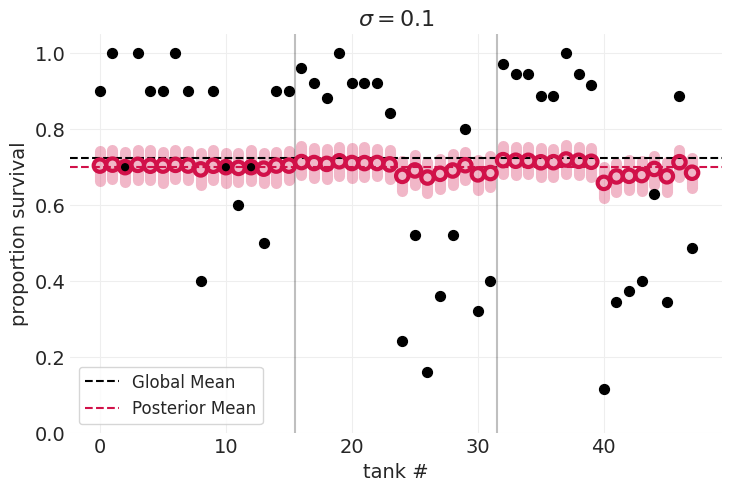

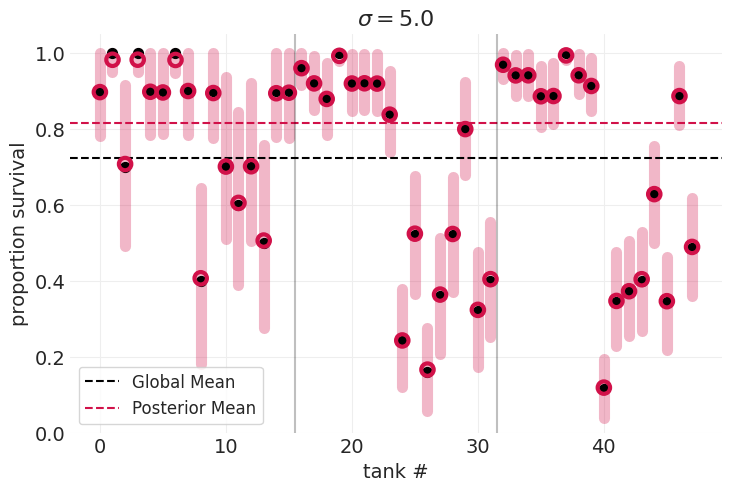

In [14]:
# Show extremes of parameter grid
for idx in [0, -1]:
    plot_survival_posterior(inferences[idx], sigmas[idx])

### Identifying the optimal $\sigma$ via Cross-validation

- $\sigma=0.1$ underfits the data, the model isn't flexible enough to capture the variability of the different tanks
- $\sigma=5.0$ overfits the data, the model is too flexible and the posterior centers around each datapoint
- $\sigma_{optimal}=?$ We can compare the LOOCV scores for models fit with each $\sigma$ value in the parameter grid, and identify the model with the lowest score.

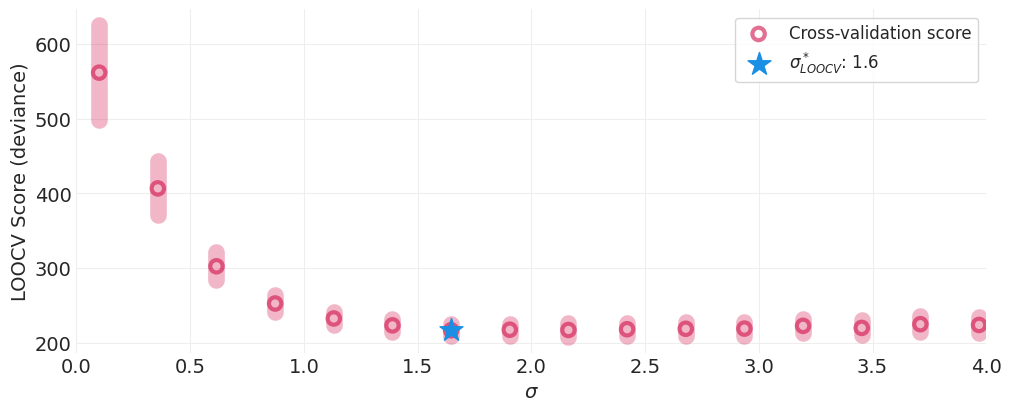

In [15]:
from collections import OrderedDict

def plot_model_comparisons(sigmas, inferences, multilevel_posterior=None):
    plt.subplots(figsize=(10, 4))
    comparisons = pm.compare(OrderedDict(zip(sigmas, inferences)), scale='deviance')
    comparisons.sort_index(inplace=True)

    utils.plot_scatter(
        xs=sigmas,
        ys=comparisons['elpd_loo'],
        color='C0',
        label='Cross-validation score'
    )
    utils.plot_errorbar(
        xs=sigmas,
        ys=comparisons['elpd_loo'],
        error_lower=comparisons['se'],
        error_upper=comparisons['se'],
        colors='C0'
    )

    # Highlight the optimal sigma
    best = comparisons[comparisons['rank'] == 0]
    plt.scatter(
        x=best.index,
        y=best['elpd_loo'],
        s=300, marker='*',
        color='C1',
        label="$\\sigma_{LOOCV}^*$:" + f" {best.index[0]:1.2}",
        zorder=20
    )
    
    # If provided, overlay the multilevel posterior (or, a scaled/offset version of it)
    if multilevel_posterior is not None:
        from scipy.stats import gaussian_kde
        kde = gaussian_kde(multilevel_inference.posterior['sigma'][0])
        sigma_grid = np.linspace(0.1, 5, 100)
        sigma_posterior = kde(sigma_grid)
        max_sigma_posterior = sigma_posterior.max()
        multiplier = (0.7 * comparisons['elpd_loo'].max()) / max_sigma_posterior
        offset =  comparisons['elpd_loo'].min() * .95
        plot_posterior = sigma_posterior * multiplier + offset

        plt.plot(
            sigma_grid,
            plot_posterior,
            color='k', linewidth=3,
            label='Multi-level Posterior'
        )
        
    plt.xlim([0, 4])
    plt.xlabel("$\\sigma$")
    plt.ylabel("LOOCV Score (deviance)")
    plt.legend()
        
    # Output optimal parameters
    optimal_sigma = best.index.values[0]
    optimal_sigma_idx = sigmas.tolist().index(optimal_sigma)

    return optimal_sigma_idx, optimal_sigma

optimal_sigma_idx, optimal_sigma = plot_model_comparisons(sigmas, inferences);

### Model with the optimal $\sigma$ identified through cross-validation

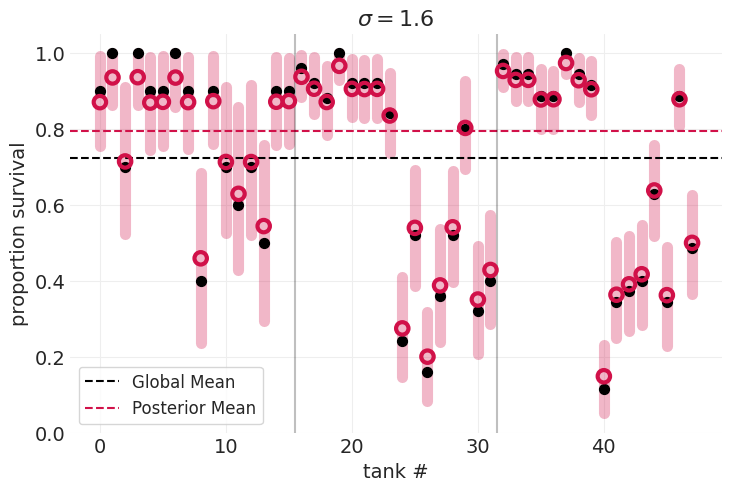

In [16]:
plot_survival_posterior(inferences[optimal_sigma_idx], sigmas[optimal_sigma_idx])

The optimal model

- is regularized, trading off bias and variance
- **demonstrates shrinkage**:
  - posterior means do not hover over datapoints, but are "pulled" toward the global mean.
  - the amount of "pull" is stronger for datapoints further away from the mean

## Building a Multilievel (Hierarchical) Model

### Automatic regularization
In principle, we can estimate optimal hyperparameter values using cross-validation like we did above, but we don't need to. We can simply learn the optimal $\sigma$ by using a hierarhcical model structure, putting a prior distribution on that variance parameter. 


### Baby's first the multi-level model

$$
\begin{align*}
S_i &\sim \text{Binomial}(D_i, p_i)\\
\text{logit}(p_i) &= \alpha_{T[i]} \\
\alpha_j &\sim \text{Normal}(\bar \alpha, \sigma_?) \\ 
\bar \alpha &\sim \text{Normal}(0, 1.5) \\
\sigma &\sim \text{Exponential}(1)
\end{align*}
$$

Note that this prior is shared amongst all groups, allowing it to perform partial pooling.

#### Plot the priors for baby's first multi-level model

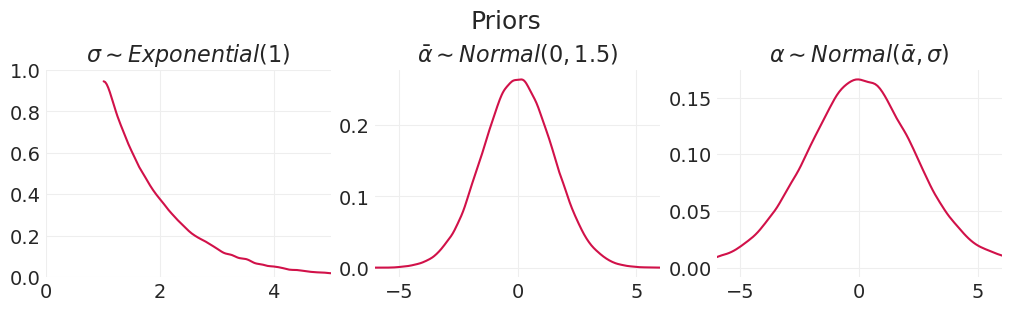

In [17]:
n_samples = 100_000
fig, axs = plt.subplots(1, 3, figsize=(10, 3))

sigmas_ = stats.expon(1).rvs(size=n_samples)
az.plot_dist(sigmas_, ax=axs[0])
axs[0].set_title('$\\sigma \sim Exponential(1)$')
axs[0].set_xlim([0, 5])
axs[0].set_ylim([0, 1])


alpha_bars_ = stats.norm(0, 1.5).rvs(size=n_samples)
az.plot_dist(alpha_bars_, ax=axs[1])
axs[1].set_xlim([-6, 6])
axs[1].set_title('$\\bar \\alpha \sim Normal(0, 1.5)$')


alphas_ = stats.norm.rvs(alpha_bars_, sigmas_)
az.plot_dist(alphas_, ax=axs[2])
axs[2].set_xlim([-6, 6])
axs[2].set_title('$\\alpha \sim Normal(\\bar \\alpha, \\sigma)$');
plt.suptitle("Priors", fontsize=18);

Note the prior distribution for $a_j$ (far right plot above) is **a mixture of Normal distributions** with different means (sampled from the $\bar a$ prior distribution) and variances (sampled from the $\sigma$ prior distribution). Therefore it isn't a Normal, but a thicker-tailed distribution, more akin to a student-t

### Fit the multi-level model

In [18]:
with pm.Model() as multilevel_model:
    
    # Priors
    sigma = pm.Exponential("sigma", 1)
    alpha_bar = pm.Normal("alpha_bar", 0, 1.5)
    alpha = pm.Normal("alpha", alpha_bar, sigma, shape=N_TANKS)
    
    # Likelihood (record log p_survived for visualization)
    p_survived = pm.Deterministic("p_survived", pm.math.invlogit(alpha))
    S = pm.Binomial('survived', n=N_TRIALS, p=p_survived, observed=N_SURVIVED)

    multilevel_inference = pm.sample()

    # Log-likelihood for model comparison
    multilevel_inference = pm.compute_log_likelihood(multilevel_inference)
    

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, alpha_bar, alpha]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.


#### Summarize the multi-level model posterior

In [19]:
az.summary(multilevel_inference, var_names=['alpha_bar', 'sigma'])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha_bar,1.339,0.253,0.821,1.778,0.004,0.003,5177.0,3356.0,1.0
sigma,1.611,0.217,1.235,2.036,0.004,0.003,2703.0,2934.0,1.0


#### The multi-level Mode's Posterior HDI overlaps the optimal value found via cross-validation

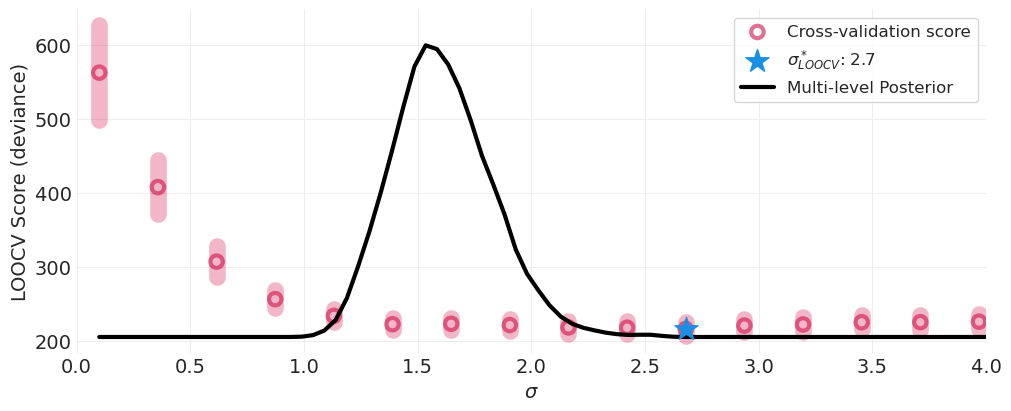

In [20]:
optimal_sigma_idx, optimal_sigma = plot_model_comparisons(sigmas, inferences, multilevel_inference.posterior);

- multi-level models learn population variation automatically, efficiently
- get regularization for free

### Comparing multi-level and fixed-sigma model

#### Fixed sigma model
$$
\begin{align*}
S_i &\sim \text{Binomial}(D_i, p_i)\\
\text{logit}(p_i) &= \alpha_{T[i]} \\
\alpha_j &\sim \text{Normal}(\bar \alpha, 1) \\ 
\bar \alpha &\sim \text{Normal}(0, 1.5) \\
\end{align*}
$$


In [21]:
with pm.Model() as fixed_sigma_model:
    # Sigma is fixed globally (no prior, and thus fewer defined params)
    sigma = 1
    
    # Prior
    alpha_bar = pm.Normal('alpha_bar', 0, 1.5)
    alpha = pm.Normal('alpha', alpha_bar, sigma, shape=N_TANKS)

    # Likelihood -- record p_survived for visualization
    p_survived = pm.Deterministic('p_survived', pm.math.invlogit(alpha))
    S = pm.Binomial('survived', n=N_TRIALS, p=p_survived, observed=N_SURVIVED)
    
    fixed_sigma_inference = pm.sample()
    fixed_sigma_inference = pm.compute_log_likelihood(fixed_sigma_inference)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha_bar, alpha]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.


In [22]:
comparison = az.compare(
    {
        "multi-level": multilevel_inference,
        "fixed-sigma": fixed_sigma_inference
    }
)

# Multi-level model has fewer effective parameters, despite having more defined parameters
assert comparison.loc["multi-level", "p_loo"] < comparison.loc["fixed-sigma", "p_loo"]
comparison

,rank,elpd_loo,p_loo,elpd_diff,weight,se,dse,warning,scale
multi-level,0,-112.215403,33.092597,0.000000,1.000000e+00,4.277200,0.000000,True,log
fixed-sigma,1,-121.714962,38.591506,9.499559,8.704149e-14,4.887092,2.917464,True,log


- multi-level model performs better in terms of LOO score (no surprise)
- multi-level model **has fewer effective parameters** despite having more programmed paramters
  - this is because the model is more efficient, and shares information across parameters
 
#### Demonstrating Posterior Uncertainty due to sample size

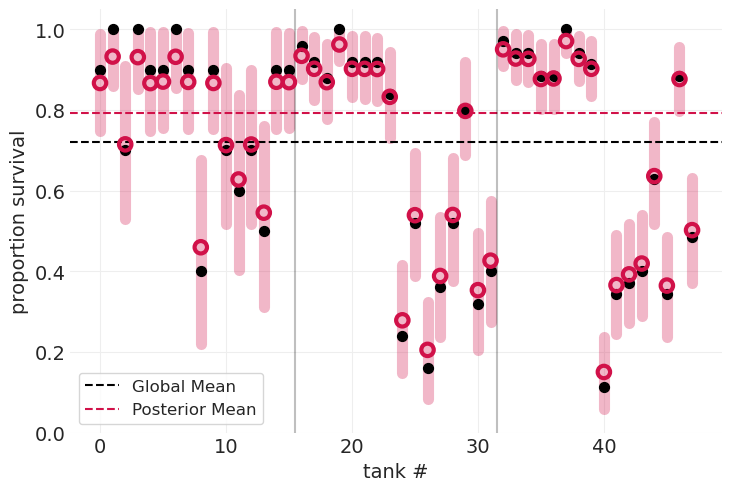

In [23]:
plot_survival_posterior(multilevel_inference) 

- Small tanks (on the far left of the above figure) have fewer observations, and thus
  - wider posterior variances
  - larger amount of shrinkage toward the global mean
- Large tanks (on the far right of the above figure) have more observations, and thus
  - tighter posterior variances
  - less shrinkage toward the global mean

## Including the presence of predators

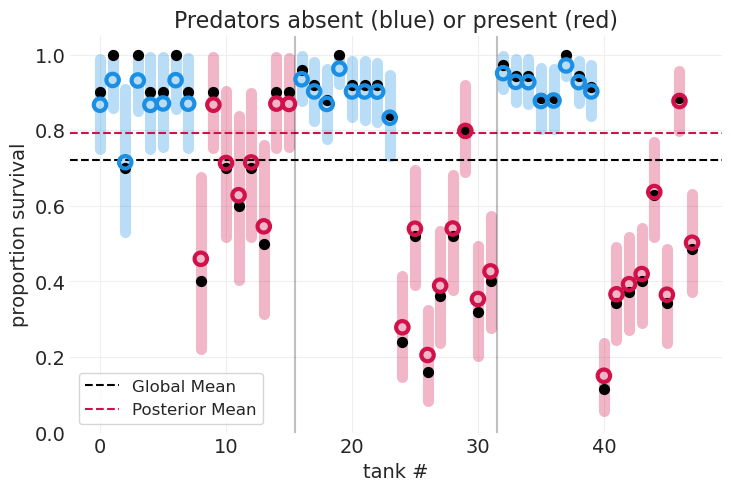

In [24]:
PREDATOR_COLORS = ["C0" if p == 1 else "C1" for p in PREDATOR_ID]

# Multi-level model without predators (same plot as above, but with different color-coding)
plot_survival_posterior(multilevel_inference, color=PREDATOR_COLORS)
plt.title("Predators absent (blue) or present (red)");

Highlighting the tanks with predators shows that the presence of predators (red) decreases survival rates

#### Multilevel model with predator effects

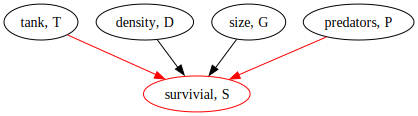

In [25]:
utils.draw_causal_graph(
    edge_list=[
        ("T", "S"),
        ("D", "S"),
        ("G", "S"),
        ("P", "S")
    ],
    node_props={
        "T": {"label": "tank, T"},
        "S": {"label": "survivial, S", "color": "red"},
        "D": {"label": "density, D"},
        "G": {"label": "size, G"},
        "P": {"label": "predators, P"},
    },
    edge_props={
        ("T", "S"): {"color": "red"},
        ("P", "S"): {"color": "red"}
    }
)

$$
\begin{align*}
S_i &\sim \text{Binomial}(D_i, p_i)\\
\text{logit}(p_i) &= \alpha_{T[i]} + \beta_P P_i\\
\beta_P &\sim \text{Normal}(0, .5) \\
\alpha_j &\sim \text{Normal}(\bar \alpha, \sigma) \\ 
\bar \alpha &\sim \text{Normal}(0, 1.5) \\
\sigma &\sim \text{Exponential}(1)
\end{align*}
$$

In [26]:
TANK_ID = np.arange(N_TANKS)
with pm.Model() as predator_model:
    
    # Global Priors
    sigma = pm.Exponential("sigma", 1)
    alpha_bar = pm.Normal("alpha_bar", 0, 1.5)
    
    # Predator-specific prior
    beta_predator = pm.Normal("beta_predator", 0, 0.5)
    
    # Tank-specific prior
    alpha = pm.Normal("alpha", alpha_bar, sigma, shape=N_TANKS)
    
    # Record p_survived for visualization
    p_survived = pm.math.invlogit(alpha[TANK_ID] + beta_predator * PREDATOR_ID)
    p_survived = pm.Deterministic('p_survived', p_survived)
    
    # Likelihood
    S = pm.Binomial("survived", n=N_TRIALS, p=p_survived, observed=N_SURVIVED)
    
    predator_inference = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, alpha_bar, beta_predator, alpha]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.


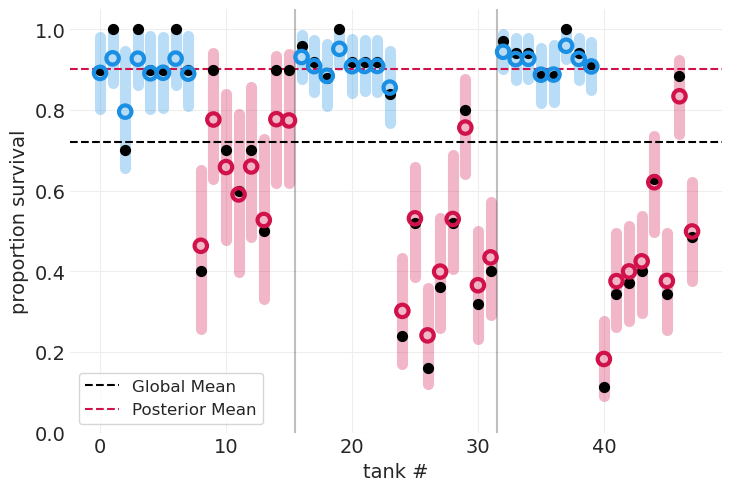

In [27]:
# Predator model
plot_survival_posterior(predator_inference, color=PREDATOR_COLORS)

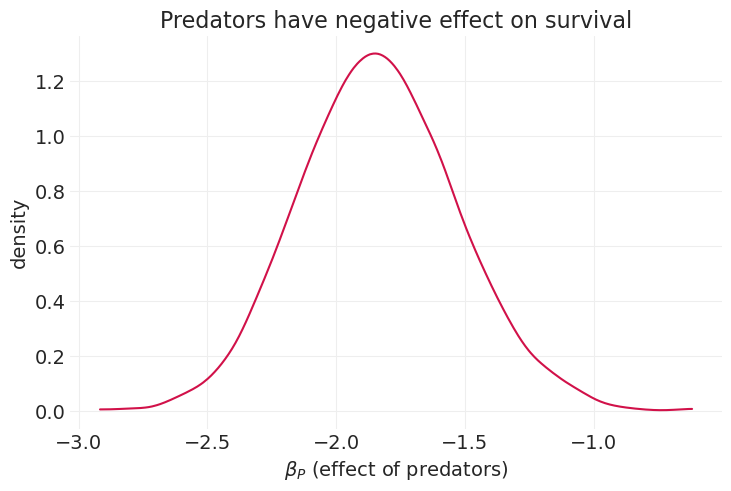

In [28]:
az.plot_dist(predator_inference.posterior["beta_predator"])
plt.xlabel("$\\beta_P$ (effect of predators)")
plt.ylabel("density")
plt.title("Predators have negative effect on survival");

### Predictions vs Inference

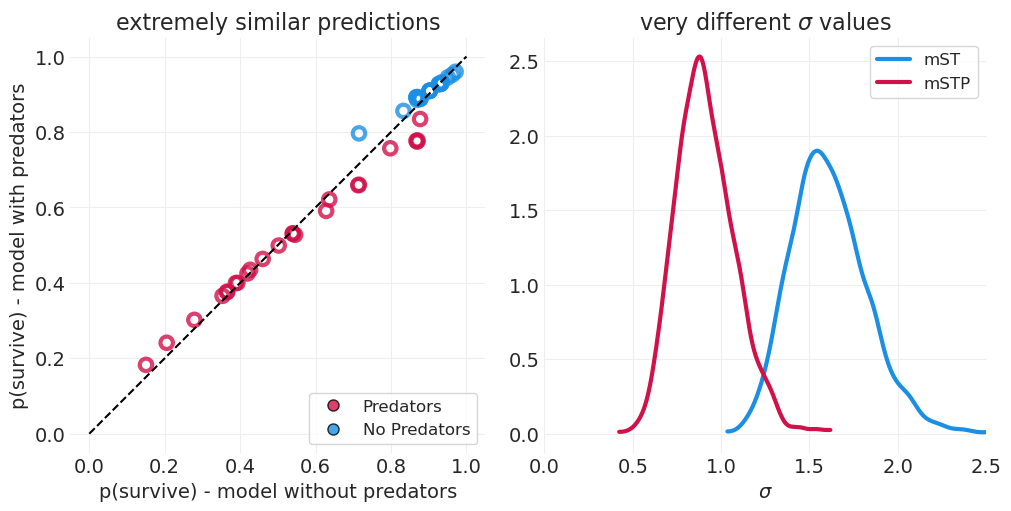

In [29]:
from matplotlib.patches import Patch
from matplotlib.lines import Line2D

# Should we probably be using the posterior predictive here, rather than the posterior?
multilevel_posterior_mean = multilevel_inference.posterior.mean(dim=('chain', 'draw'))['p_survived']
predator_posterior_mean = predator_inference.posterior.mean(dim=('chain', 'draw'))['p_survived']


fig, axs = plt.subplots(1, 2, figsize=(10, 5))

plt.sca(axs[0])
for x, y, c in zip(multilevel_posterior_mean, predator_posterior_mean, PREDATOR_COLORS):
    utils.plot_scatter(xs=x, ys=y, color=c, alpha=.8)
    
plt.plot((0, 1), (0, 1), 'k--')
plt.xlabel("p(survive) - model without predators")
plt.ylabel("p(survive) - model with predators")

# Legend
legend_kwargs = dict(marker='o', color='none', markersize=8, alpha=.8)
legend_elements = [
    Line2D([0], [0], markerfacecolor='C0', label='Predators', **legend_kwargs),
    Line2D([0], [0], markerfacecolor='C1', label='No Predators', **legend_kwargs),
]
plt.legend(handles=legend_elements, loc='lower right')
plt.title("extremely similar predictions")
plt.axis('square');

plt.sca(axs[1]);
az.plot_dist(multilevel_inference.posterior['sigma'], ax=axs[1], color='C1', label='mST', plot_kwargs={"lw": 3})
az.plot_dist(predator_inference.posterior['sigma'], ax=axs[1], color='C0', label='mSTP', plot_kwargs={"lw": 3})
plt.xlim([0, 2.5])
plt.xlabel("$\sigma$")
plt.title("very different $\sigma$ values");


- Model without predators can predict survival just as well as the model with predators
- This is because the multi-level model can still capture the tank-level variablity through the individual $\alpha_T$
- However, adding predators "explains away" a lot more of the tank-level variance. This is demonstrated by the $\sigma$ values for tank-level variability being smaller in the predator model. Thus the predator model has to consider less tank-based variablity in order to capture the variability in survival.

## Varying Effect Superstitions
- ~~Partial pooling requires random sampling from the population ❌~~
- ~~Number of categories / units must be large ❌~~
- ~~Variation must be Gaussian ❌~~
  - Gaussian priors can learn non-Gaussian distributions
  
## Practical Difficulties
- Using multiple clusters simultaneously (e.g. participants AND stories)
- Sampling efficiency -- recoding (e.g. centered/non-centered priors)
- Partial pooling on other parameters (e.g. slopes) or unobserved confounds?

These difficulties will be addressed in upcoming lectures on Multi-level models. 😅

# BONUS: Fixed Effects, Multilevel Models, & Mundlak Machines

## Random Confounds

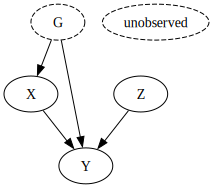

In [30]:
utils.draw_causal_graph(
    edge_list=[
        ("G", "X"),
        ("G", "Y"),
        ("X", "Y"),
        ("Z", "Y")
    ], 
    node_props={
        "G": {"style": "dashed"},
        "unobserved": {"style": "dashed"}
    }
)

**Estimand**: Influence of $X$ on $Y$


- Outcome $Y$ (e.g. tadpole survival)
- Individual-level traits $X$
- Group-level traits $Z$
- Unobserved tank effects $G$
  - effects both $X$ and $Y$
  - e.g. tank temperature
  - creates a backdoor path from $X$ to $Y$ (via fork)
  - We can't directly measure $G$.
  - However, if we have repeat observations, there's some tricks up our sleeve that we can use.
 
**Estimator?**

1. Fixed Effects model
2. Multi-level model
3. Muldlak Machine

### Simulate some data

In [31]:
# Generate data
np.random.seed(12)

N_GROUPS = 30
N_IDS = 200
ALPHA = -2  # p(Y) < .5 on average
BETA_ZY = -0.5 
BETA_XY = 1

# Group-level data
GROUP = np.random.choice(np.arange(N_GROUPS).astype(int), size=N_IDS, replace=True)
Z = stats.norm.rvs(size=N_GROUPS)  # Observed group traits
U = stats.norm(0, 1.5).rvs(size=N_GROUPS)  # Unobserved group confound

# Individual-level data
X = stats.norm.rvs(U[GROUP])  # Observed individual traits
p = utils.invlogit(ALPHA + BETA_XY * X + U[GROUP] + BETA_ZY * Z[GROUP])
Y = stats.bernoulli.rvs(p=p)

#### Show below that groups aren't randomly sampled

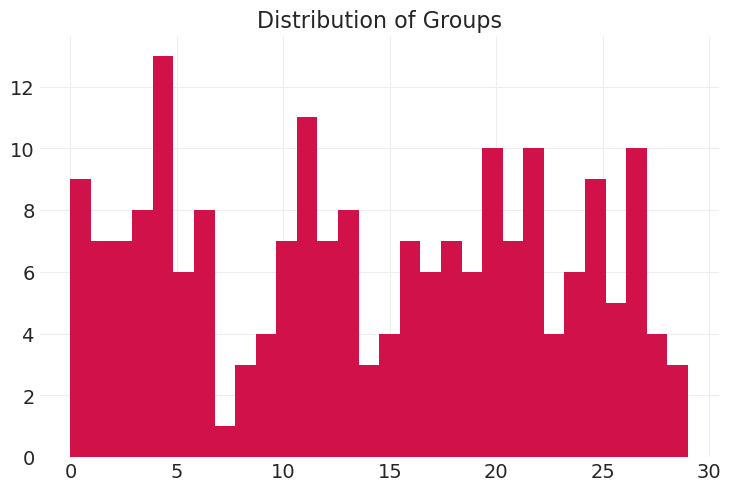

In [32]:
plt.hist(GROUP, bins=N_GROUPS);
plt.title("Distribution of Groups");

### Naive Model

$$
\begin{align*}
Y &\sim \text{Bernoulli}(p) \\
\text{logit}(p_i) &= \alpha + \beta_{X}X + \beta_{Z} Z_{G[i]} \\
\alpha &\sim \text{Normal}(0, 10) \\
\beta_* &\sim \text{Normal}(0, 1)
\end{align*}
$$

In [33]:
with pm.Model() as naive_model:
    
    # Priors
    fixed_sigma = 10  # no pooling
    alpha = pm.Normal("alpha", 0, fixed_sigma)  # no group effects
    beta_XY = pm.Normal("beta_XY", 0, 1)
    beta_ZY = pm.Normal("beta_ZY", 0, 1)
    
    # Likelihood
    p = pm.math.invlogit(alpha + beta_XY * X + beta_ZY * Z[GROUP])
    pm.Bernoulli("Y_obs", p=p, observed=Y)
    naive_inference = pm.sample()


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta_XY, beta_ZY]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.


### Fixed effect Model

$$
\begin{align*}
Y &\sim \text{Bernoulli}(p) \\
\text{logit}(p_i) &= \alpha_{G[i]} + \beta_{X}X_i + \beta_{Z} Z_{G[i]} \\
\alpha_j &\sim \text{Normal}(0, 10) \\
\beta_* &\sim \text{Normal}(0, 1)
\end{align*}
$$

- Estimate a different average rate for each group **without pooling**
- $\beta_Z$ and $\beta_X$ are global parameters
- Accounts for group-level confounding effect of $G$ (via offsets for each group)
- Problems:
  - Cannot identify any group-level effects $Z$
    - $Z$ is unidentifiable because it's added globally
      - there are an infinite number of equivalent combinations of $\alpha_{G[i]} + \beta_Z Z_{G[i]}$
      - can't separate contribution of $\beta_Z$ from $\alpha$ 
    - Can't include group-level predictors with Mixed-effect model
  - Inefficient

In [34]:
with pm.Model() as fixed_effects_model:
    
    # Priors
    fixed_sigma = 10  # no pooling
    alpha = pm.Normal("alpha", 0, fixed_sigma, shape=N_GROUPS)
    beta_XY = pm.Normal("beta_XY", 0, 1)
    beta_ZY = pm.Normal("beta_ZY", 0, 1)
    
    # Likelihood
    p = pm.math.invlogit(alpha[GROUP] + beta_XY * X + beta_ZY * Z[GROUP])
    pm.Bernoulli("Y_obs", p=p, observed=Y)
    fixed_effect_inference = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta_XY, beta_ZY]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 3 seconds.


### Multilevel Model


$$
\begin{align*}
Y &\sim \text{Bernoulli}(p) \\
\text{logit}(p_i) &= \alpha_{G[i]} + \beta_{X}X + \beta_{Z} Z_{G[i]} \\
\beta_* &\sim \text{Normal}(0, 1) \\
\alpha_j &\sim \text{Normal}(\bar a, \tau) \\
\bar a &\sim \text{Normal}(0, 1) \\
\tau &\sim \text{Exponential}(10)
\end{align*}
$$

- Estimate a different average rate for each group **with partial pooling**
- better estimates for $G$ effects
- at the expense of estimating $X$ effects
  - compromises estimating the confound so that it can get better estimates for the group
- CAN identify $Z$ effects
  - CAN incorporate group-level predictors

In [35]:
with pm.Model() as multilevel_model:
    
    # Priors
    alpha_bar = pm.Normal("alpha_bar", 0, 1)
    tau = pm.Exponential('tau', 1)
    
    # NOTE: non-centered prior reparameterization for numerical stability
    z = pm.Normal("z", 0, 1, shape=N_GROUPS)
    alpha = alpha_bar + z * tau
    
    beta_XY = pm.Normal("beta_XY", 0, 1)
    beta_ZY = pm.Normal("beta_ZY", 0, 1)
    
    # Likelihood
    p = pm.math.invlogit(alpha[GROUP] + beta_XY * X + beta_ZY * Z[GROUP])
    pm.Bernoulli("Y_obs", p=p, observed=Y)
    multilevel_inference = pm.sample(target_accept=.95)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha_bar, tau, z, beta_XY, beta_ZY]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 4 seconds.


### Compare Models

In [36]:
def compare_model_posteriors(inferences, labels, variable='beta_XY'):
    """Helper function to plot model posteriors
    """
    groundtruth = BETA_XY if variable == 'beta_XY' else BETA_ZY
    for ii, inference in enumerate(inferences):
        az.plot_dist(
        inference.posterior[variable].values,
        color=f'C{ii}',
        label=labels[ii]
    )
    plt.axvline(groundtruth, label="actual", color='k', linestyle='--')
    plt.title(f"posterior {variable}")
    plt.legend();

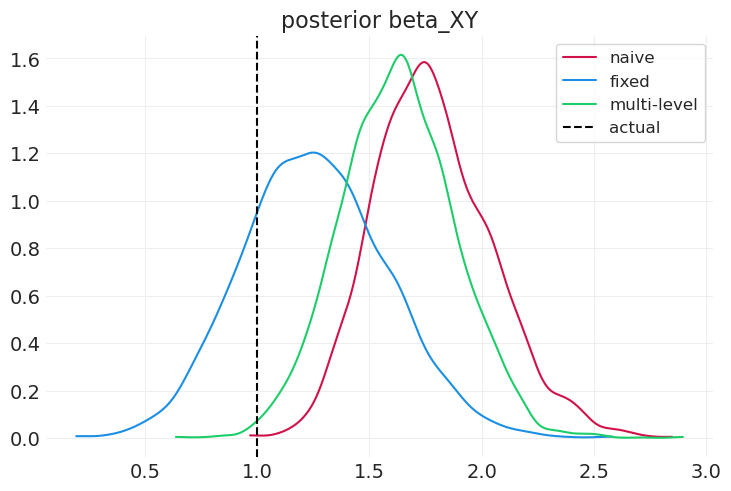

In [37]:
compare_model_posteriors(
    inferences=[naive_inference, fixed_effect_inference, multilevel_inference],
    labels=['naive', 'fixed', 'multi-level']
)

Fixed effect models are better (though not great in this simulation) than multi-level (and naive) model at identifying the individual-level group confound, but can't identify any group effects.

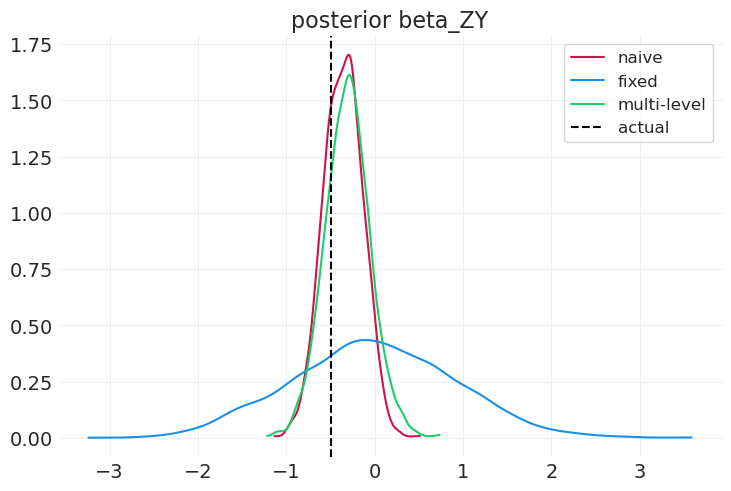

In [38]:
compare_model_posteriors(
    inferences=[naive_inference, fixed_effect_inference, multilevel_inference],
    labels=['naive', 'fixed', 'multi-level'],
    variable='beta_ZY'
)

Multi-level models can identify the group effects, though it can't identify the confound. Fixed effect models can't say much about the group level effects.

- If interested completely in _prediction_, multi-level models are better
- If interested in _inference_ (i.e. via do-calculus or counterfactuals), you might want to use fixed effects (though group-level prediction accuracy may be poor)

### Mundlak Machines

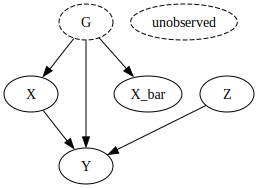

In [39]:
utils.draw_causal_graph(
    edge_list=[
        ("G", "X"),
        ("G", "Y"),
        ("G", "X_bar"),
        ("X", "Y"),
        ("Z", "Y")
    ], 
    node_props={
        "G": {"style": "dashed"},
        "unobserved": {"style": "dashed"}
    }
)

#### Statistical Model

$$
\begin{align*}
Y &\sim \text{Bernoulli}(p) \\
\text{logit}(p_i) &= \alpha_{G[i]} + \beta_{X}X + \beta_{Z} Z_{G[i]} + \beta_{\bar X} \bar X_{G[i]}\\
\beta_* &\sim \text{Normal}(0, 1) \\
\alpha_j &\sim \text{Normal}(\bar a, \tau) \\
\bar a &\sim \text{Normal}(0, 1) \\
\tau &\sim \text{Exponential}(10)
\end{align*}
$$

- Estimate a different average rate for each group **with partial pooling**
- Takes advantage of the idea that conditioning on a descendent in a graph can (at least partially) deconfound a the parent/ancestor variable.
- Uses the group-level mean as child of the confounding variables to reduce it's confounding effect.
- Problems:
  - somewhat inefficient
    - because groups have different size, we also need to consider the uncertainty in the estimation of the group-level means, which the Mundlak machine ignores


In [40]:
# Group-level average
Xbar = np.array([X[GROUP==g].mean() for g in range(N_GROUPS)])

with pm.Model() as mundlak_model:
    # Priors
    alpha_bar = pm.Normal("alpha_bar", 0, 1)
    tau = pm.Exponential("tau", 1)
    z = pm.Normal("z", 0, 1, shape=N_GROUPS)
    
    # Note: uncentered reparameterization
    alpha = alpha_bar + z * tau
    
    beta_XY = pm.Normal("beta_XY", 0, 1)
    beta_ZY = pm.Normal("beta_ZY", 0, 1)
    beta_Xbar_Y = pm.Normal("beta_XbarY", 0, 1)
    
    # Likelihood
    p = pm.math.invlogit(alpha[GROUP] + beta_XY * X + beta_ZY * Z[GROUP] + beta_Xbar_Y * Xbar[GROUP])
    pm.Bernoulli("Y_obs", p=p, observed=Y)
    mundlak_inference = pm.sample(target_accept=.95)
    

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha_bar, tau, z, beta_XY, beta_ZY, beta_XbarY]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 4 seconds.


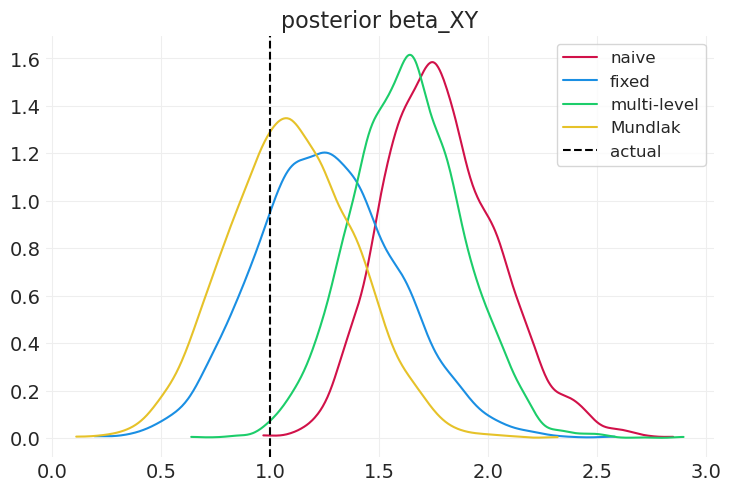

In [41]:
compare_model_posteriors(
    inferences=[naive_inference, fixed_effect_inference, multilevel_inference, mundlak_inference],
    labels=['naive', 'fixed', 'multi-level', 'Mundlak']
)

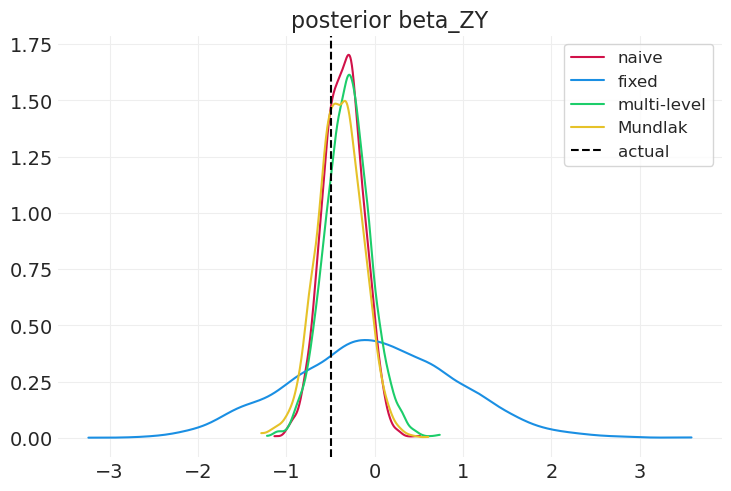

In [42]:
compare_model_posteriors(
    inferences=[naive_inference, fixed_effect_inference, multilevel_inference, mundlak_inference],
    labels=['naive', 'fixed', 'multi-level', 'Mundlak'],
    variable='beta_ZY'
)

Mundlak machines are able to capture both Treatment and Group-level effects

## Latent Mundlak Machine (aka "Full Luxury Bayes")

- We model not only the observed outcome $Y$ (as a function of $X, G, Z$), but also the treatment $X$ (as a function of the confound G).
- Unlike the Mundlak machine, which collapses $\bar X$ into a point estimate, thus ignoring the uncertainty in that mean estimate, the Latent Mundlak estimates this uncertainty by including the submodel on $X$.
- akin to a measurment error model

So the original graph:

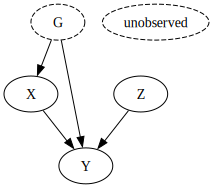

In [43]:
utils.draw_causal_graph(
    edge_list=[
        ("G", "X"),
        ("G", "Y"),
        ("X", "Y"),
        ("Z", "Y")
    ], 
    node_props={
        "G": {"style": "dashed"},
        "unobserved": {"style": "dashed"}
    }
)

#### 1. $X$ sub-model

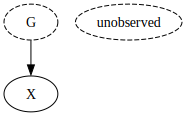

In [44]:
utils.draw_causal_graph(
    edge_list=[
        ("G", "X"),
    ], 
    node_props={
        "G": {"style": "dashed"},
        "unobserved": {"style": "dashed"}
    }
)

$$
\begin{align*}
X_i &\sim \text{Normal}(\mu_{X}, \sigma_X) \\
\mu_{X_i} &= \alpha_X + \beta_{GX} U_{G[i]} \\
U_G &\sim \text{Normal}(0, 1) \\
\alpha_X &\sim \text{Normal}(0, 1) \\
\sigma_X &\sim \text{Exponential}(1)
\end{align*}
$$

#### 2. $Y$ sub-model

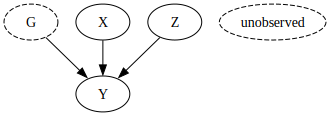

In [45]:
utils.draw_causal_graph(
    edge_list=[
        ("G", "Y"),
        ("X", "Y"),
        ("Z", "Y")
    ], 
    node_props={
        "G": {"style": "dashed"},
        "unobserved": {"style": "dashed"}
    }
)

$$
\begin{align*}
Y_i &\sim \text{Bernoulli}(p_i) \\
\text{logit}(p_i) &= \alpha_{Y,G[i]} + \beta_{XY}X_i + \beta_{GY} U_{G[i]}\\
U_G &\sim \text{Normal}(0, 1) \\
\beta_* &\sim \text{Normal}(0, 1) \\
\alpha_{GY} &\sim \text{Normal}(\bar a, \tau) \\
\bar a &\sim \text{Normal}(0, 1) \\
\tau &\sim \text{Exponential}(1)
\end{align*}
$$

In [46]:
with pm.Model() as latent_mundlak_model:
    # Unobserved variable (could use various priors here)
    G = pm.Normal("u_X", 0, 1, shape=N_GROUPS)
    
    # ----------
    # X sub-model
    # X Priors
    alpha_X = pm.Normal("alpha_X", 0, 1)
    beta_GX = pm.Exponential("beta_GX", 1)
    sigma_X = pm.Exponential("sigma_X", 1)
    
    # X Likelihood
    mu_X = alpha_X + beta_GX * G[GROUP]
    X_ = pm.Normal("X", mu_X, sigma_X, observed=X)
    
    # ----------
    # Y sub-model
    # Y priors
    tau = pm.Exponential("tau", 1)
    
    # Note: uncentered reparameterization
    z = pm.Normal("z", 0, 1, size=N_GROUPS)
    alpha_bar = pm.Normal("alph_bar", 0, 1)
    alpha = alpha_bar + tau * z
    
    beta_XY = pm.Normal("beta_XY", 0, 1)
    beta_ZY = pm.Normal("beta_ZY", 0, 1)
    beta_GY = pm.Normal("beta_GY", 0, 1)
    
    # Y likelihood
    p = pm.math.invlogit(alpha[GROUP] + beta_XY * X_ + beta_ZY * Z[GROUP] + beta_GY * G[GROUP])
    pm.Bernoulli("Y", p=p, observed=Y)
    
    latent_mundlak_inference = pm.sample(target_accept=.95)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [u_X, alpha_X, beta_GX, sigma_X, tau, z, alph_bar, beta_XY, beta_ZY, beta_GY]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 8 seconds.


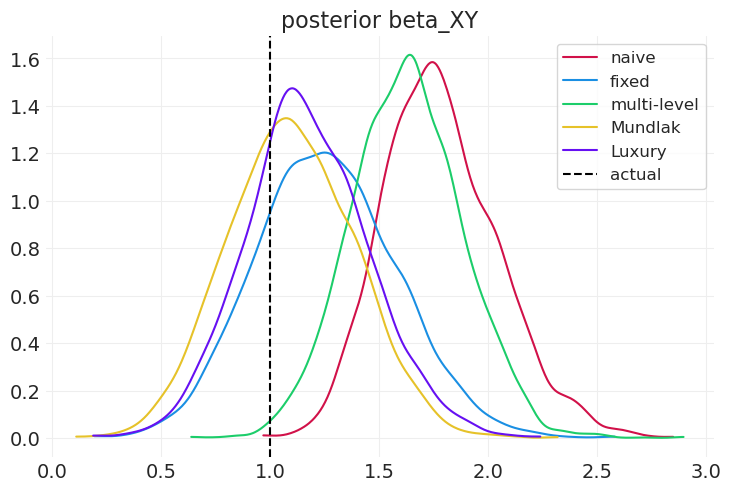

In [47]:
compare_model_posteriors(
    inferences=[naive_inference, fixed_effect_inference, multilevel_inference, mundlak_inference, latent_mundlak_inference],
    labels=['naive', 'fixed', 'multi-level', 'Mundlak', 'Luxury']
)

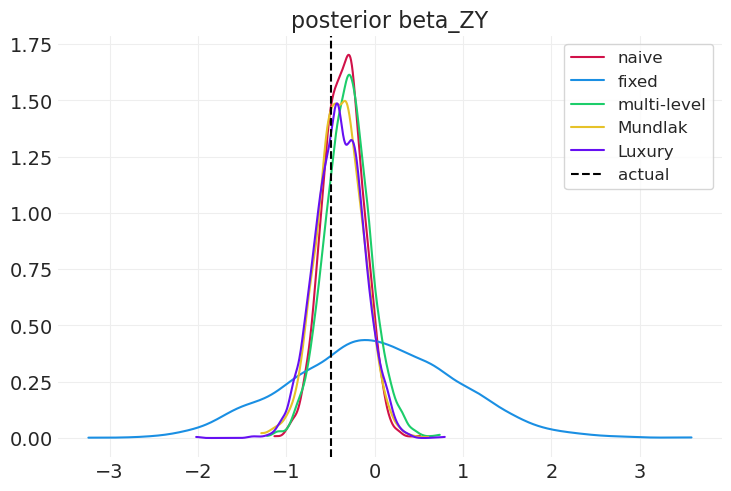

In [48]:
compare_model_posteriors(
    inferences=[naive_inference, fixed_effect_inference, multilevel_inference, mundlak_inference, latent_mundlak_inference],
    labels=['naive', 'fixed', 'multi-level', 'Mundlak', 'Luxury'],
    variable='beta_ZY'
)

## Random Confounds: Summary
- Should you use fixed effects? sometimes, but generally Full-luxury is the way to go
- Should you use Mundlak Machine / Average X?
  - Sometimes: it does simplify numerical compuation, but at the expense of losing uncertainty estimation.
  - Usually have the compute power anyways, so why not just use FLB?
- Use full generative model
  - no single solution, so just be explicit about model